In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cluster import KMeans

# -------------------------
# Ön İşlem ve Veri Hazırlığı
# -------------------------
# Veri setini yükleyip gereksiz sütunları kaldırıyoruz.
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerlerin düzenlenmesi
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özniteliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

2 küme için -> Inertia: 1075736195473310080.0000, Silhouette Score: 0.9930
3 küme için -> Inertia: 482405772577805952.0000, Silhouette Score: 0.9917
4 küme için -> Inertia: 131006003491979120.0000, Silhouette Score: 0.9865
5 küme için -> Inertia: 77414813358782928.0000, Silhouette Score: 0.9778


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

6 küme için -> Inertia: 61558376295565192.0000, Silhouette Score: 0.9592
7 küme için -> Inertia: 30930378079947296.0000, Silhouette Score: 0.9589
8 küme için -> Inertia: 19004890142916444.0000, Silhouette Score: 0.9599
9 küme için -> Inertia: 14216449138354642.0000, Silhouette Score: 0.9595


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


10 küme için -> Inertia: 10137456310550222.0000, Silhouette Score: 0.9596


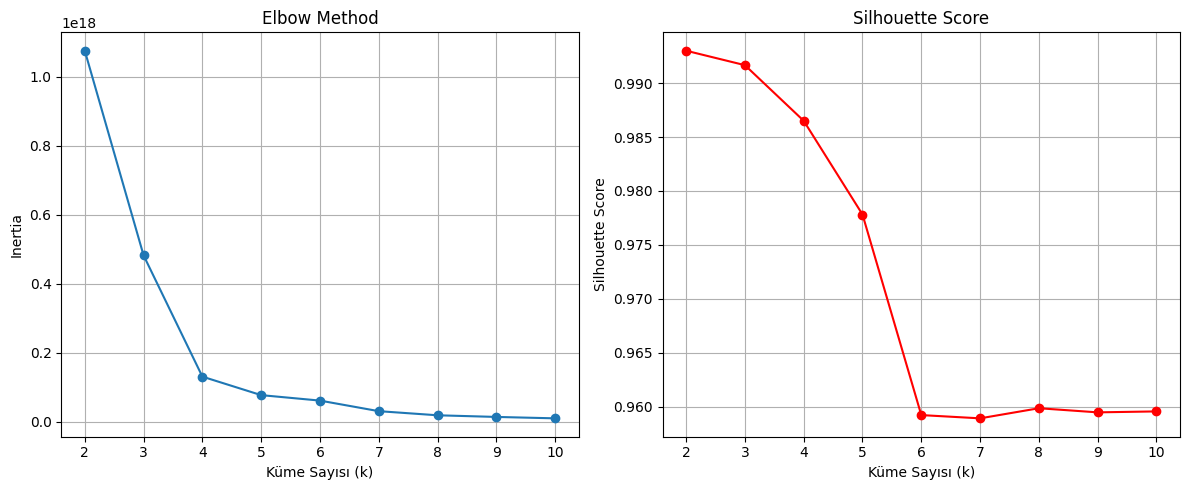

In [ ]:
from sklearn.metrics import silhouette_score

# -------------------------
# Optimum Küme Sayısı Belirleme
# -------------------------
# 2'den 10'a kadar farklı küme sayıları için hesaplama yapıyoruz.
inertia_list = []         # Her k için inertia değerlerini saklamak için
silhouette_scores = []      # Her k için silhouette score değerlerini saklamak için

kume_araligi = range(2, 11)  # 2 ile 10 arasındaki küme sayıları

for k in kume_araligi:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia = kmeans.inertia_
    inertia_list.append(inertia)
    
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)
    
    print(f"{k} küme için ->    : {inertia:.4f}, Silhouette Score: {score:.4f}")

# -------------------------
# Grafikleri Çizdirme
# -------------------------
plt.figure(figsize=(12, 5))

# Elbow Yöntemi Grafiği (Inertia)
plt.subplot(1, 2, 1)
plt.plot(kume_araligi, inertia_list, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

# Silhouette Score Grafiği
plt.subplot(1, 2, 2)
plt.plot(kume_araligi, silhouette_scores, marker='o', color='red')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()
